### Question 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

np.random.seed(0) # for reproducibility

### Parameters and data sampling function

In [3]:
# given parameters
r_minus1 = 2.0
r_plus1 = 4.0
sigma = 1.0
priors = [0.5, 0.5]

In [4]:
def sample_concentric_data(num_samples, r_minus=r_minus1, r_plus=r_plus1, sigma=sigma, priors=priors):
    """
    Generate samples based on this formula: x = rl [cos(θ), sin(θ)] + n 
    where l in element (-1, 1)
    """
    # sample labels according to priors
    # first sample in {0,1} then map 0 -> -1, 1 -> +1
    y01 = np.random.choice([0, 1], size=num_samples, p=priors)
    y = np.where(y01 == 0, -1, +1)

    theta = np.random.uniform(-np.pi, np.pi, size=num_samples) # theta in [-pi, pi]
    r = np.where(y == -1, r_minus, r_plus) # radius
    X_circle = np.stack([np.cos(theta), np.sin(theta)], axis=1) * r[:, None] # x = rl [cos(θ), sin(θ)]

    # add Gaussian noise n ~ N(0, σ^2 I)
    noise = np.random.normal(loc=0.0, scale=sigma, size=X_circle.shape)
    X = X_circle + noise

    # shuffle
    idx = np.random.permutation(num_samples)
    return X[idx], y[idx]

In [5]:
X_train, y_train = sample_concentric_data(1000)   # 1000 iid training samples
X_test,  y_test  = sample_concentric_data(10000)  # 10000 iid test samples

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape,  y_test.shape)

Train: (1000, 2) (1000,)
Test : (10000, 2) (10000,)


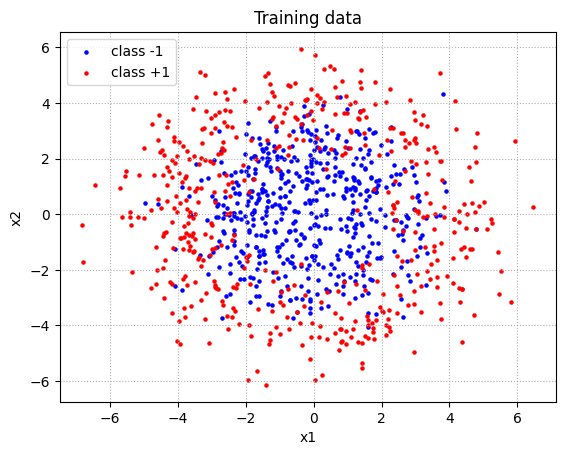

In [6]:
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], s=5, c="b", label="class -1")
plt.scatter(X_train[y_train == +1, 0], X_train[y_train == +1, 1], s=5, c="r", label="class +1")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Training data")
plt.legend()
plt.grid(True, ls=":")
plt.show()

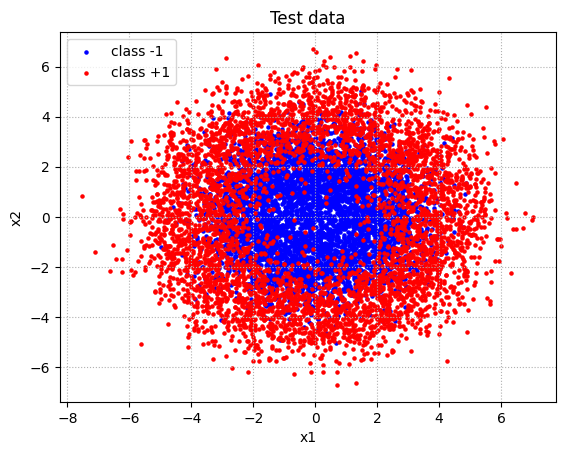

In [7]:
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], s=5, c="b", label="class -1")
plt.scatter(X_test[y_test == +1, 0], X_test[y_test == +1, 1], s=5, c="r", label="class +1")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Test data")
plt.legend()
plt.grid(True, ls=":")
plt.show()

### SVM

In [8]:
# standardize
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [9]:
# hyperparameters values for grid search
C_values     = [0.01, 0.1, 1, 10, 100, 1000, 10000]
gamma_values = [0.0001, 0.001, 0.01, 0.1]

param_grid = {
    "C": C_values,
    "gamma": gamma_values,
    "kernel": ["rbf"] # only RBF kernel
}

# k-fold CV
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

In [10]:
svm = SVC() # support vector classifier

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=kfold,
    scoring="accuracy",
    n_jobs=8,
    return_train_score=False
)

# run grid search
grid_search.fit(X_train_std, y_train)

print("Best parameters from CV:", grid_search.best_params_)
print("Best CV accuracy: {:.4f}".format(grid_search.best_score_))


Best parameters from CV: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV accuracy: 0.8350


(28,)
(7, 4)


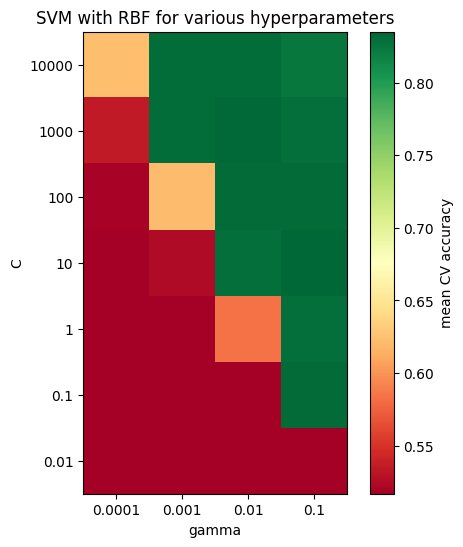

In [11]:
mean_scores = grid_search.cv_results_["mean_test_score"]
scores_matrix = mean_scores.reshape(len(C_values), len(gamma_values)) # reshape for color map
print(mean_scores.shape)
print(scores_matrix.shape)

# visualize
plt.figure(figsize=(6, 6))
im = plt.imshow(scores_matrix, origin="lower", interpolation="nearest", cmap='RdYlGn')

# tick marks and labels
plt.xticks(np.arange(len(gamma_values)), gamma_values)
plt.yticks(np.arange(len(C_values)), C_values)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("SVM with RBF for various hyperparameters")

plt.colorbar(im, label="mean CV accuracy") # color bar
plt.show()

SVC(C=10, gamma=0.1)
Test accuracy: 0.8262
Estimated P(error): 0.1738


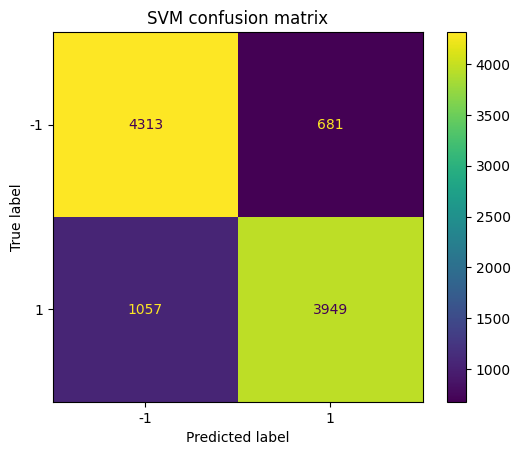

In [12]:
best_svm = grid_search.best_estimator_ # best estimator
print(best_svm)

# Eval on test set
y_test_pred = best_svm.predict(X_test_std)

cm = confusion_matrix(y_test, y_test_pred, labels=[-1, +1])
acc = accuracy_score(y_test, y_test_pred)
p_error = 1.0 - acc   # minimum probability of error estimate

print("Test accuracy: {:.4f}".format(acc))
print("Estimated P(error): {:.4f}".format(p_error))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot()
plt.title(f"SVM confusion matrix")
plt.show()

In [13]:
# decision boundary with train data
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)

Z = best_svm.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

print(xx.shape, yy.shape, Z.shape)

(400, 400) (400, 400) (400, 400)


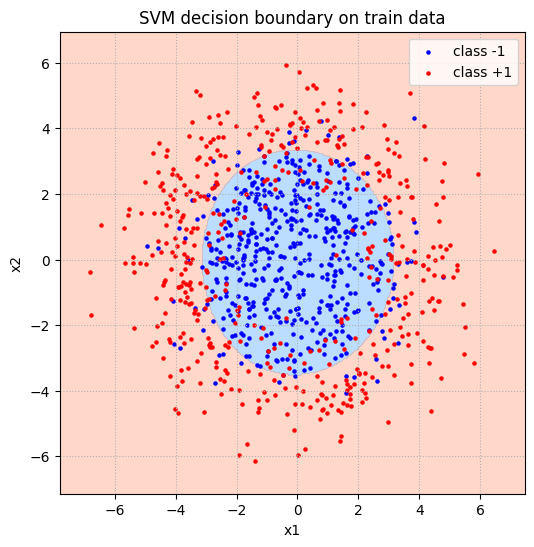

In [14]:
# SVM decision boundary on train data
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=['dodgerblue', 'coral']) # decision regions

# training points
plt.scatter(
    X_train[y_train == -1, 0],
    X_train[y_train == -1, 1],
    s=5, label="class -1", c="b"
)
plt.scatter(
    X_train[y_train == +1, 0],
    X_train[y_train == +1, 1],
    s=5, label="class +1", c="r"
)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("SVM decision boundary on train data")
plt.legend()
plt.grid(True, ls=":")
plt.show()

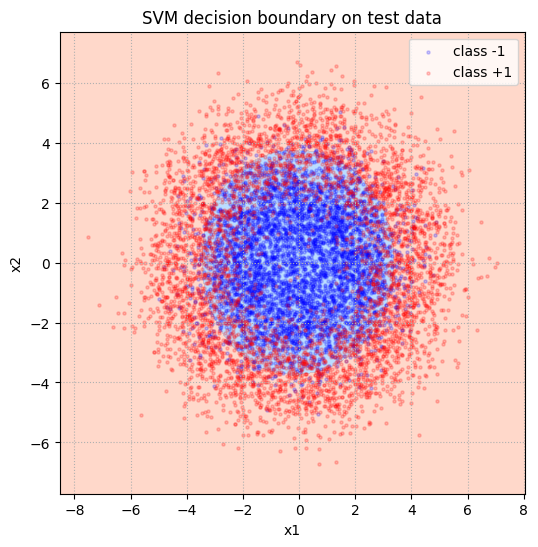

In [15]:
# SVM decision boundary on test data
x_min, x_max = X_test[:, 0].min() - 1.0, X_test[:, 0].max() + 1.0
y_min, y_max = X_test[:, 1].min() - 1.0, X_test[:, 1].max() + 1.0

xx_test, yy_test = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)

Z_test = best_svm.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
Z_test = Z_test.reshape(xx_test.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx_test, yy_test, Z_test, levels=[-1, 0, 1], alpha=0.3, colors=['dodgerblue', 'coral'])  # decision regions in std space

# test points
plt.scatter(
    X_test[y_test == -1, 0],
    X_test[y_test == -1, 1],
    s=5, label="class -1", alpha=0.2, c = "b"
)
plt.scatter(
    X_test[y_test == +1, 0],
    X_test[y_test == +1, 1],
    s=5, label="class +1", alpha=0.2, c = "r"
)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("SVM decision boundary on test data")
plt.legend()
plt.grid(True, ls=":")
plt.show()


### MLP
Similar to the assignment 3 (no function this time though)

In [16]:
import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# skorch (PyTorch wrapper for scikit-learn)
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler
from skorch.dataset import ValidSplit

# CV utilities
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# create labels for PyTorch
dimension = X_train.shape[1] # 2
num_class = 2
P_list = [2, 4, 8, 16, 32, 64]  # candidate numbers of hidden units
epochs = 100
batch_size = 64
patience = 10
LR = 1e-3

X_train_mlp = X_train.astype(np.float32)
X_test_mlp  = X_test.astype(np.float32)

y_train_mlp = (y_train == 1).astype(np.int64)
y_test_mlp = (y_test == 1).astype(np.int64)


In [19]:
# MLP
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_units=8, output_size=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# print network architecture (Example)
model = MLP(dimension, 8, num_class)
print(model)

MLP(
  (fc1): Linear(in_features=2, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
)


In [20]:
base = NeuralNetClassifier(
    module=MLP,
    module__input_size=dimension,
    module__output_size=num_class,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    max_epochs=100,
    lr=1e-3,
    batch_size=64,
    device=device,
    train_split=ValidSplit(0.2, random_state=0),   # internal val split
    callbacks=[
        EarlyStopping(patience=10, monitor='valid_loss'),
        LRScheduler(
            policy='ReduceLROnPlateau',
            monitor='valid_loss',
            patience=5
        ),
    ],
    verbose=0,
)

# Cross-validation to select P
print("-> Running 10-fold CV to select P ...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=base,
    param_grid={"module__hidden_units": P_list},
    cv=cv,
    scoring="accuracy",
    n_jobs=8,
    refit=True,   # refit best model on full training set
)

grid.fit(X_train_mlp, y_train_mlp)

print("Best params:", grid.best_params_)
print("Best CV accuracy: {:.4f}".format(grid.best_score_))

# Plot CV performance vs P
mean_scores = []
for P in P_list:
    # collect mean_test_score entries for this P
    mask = (grid.cv_results_["param_module__hidden_units"] == P)
    mean_scores.append(grid.cv_results_["mean_test_score"][mask].mean())


-> Running 10-fold CV to select P ...


c:\Users\USER\OneDrive - Northeastern University\Desktop\Python_for_DS\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'module__hidden_units': 16}
Best CV accuracy: 0.8310


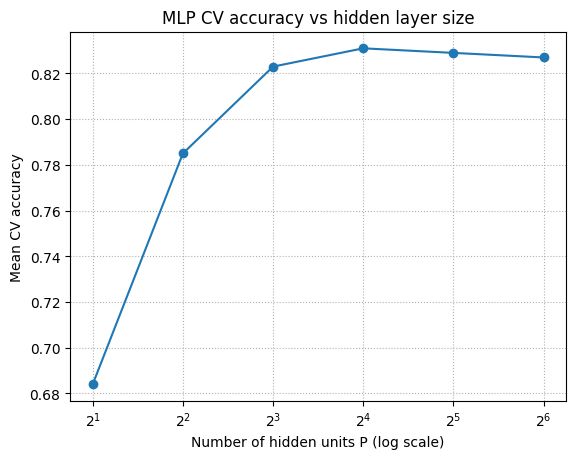

In [21]:
plt.figure()
plt.plot(P_list, mean_scores, marker="o")
plt.xscale("log", base=2) # use log scale for better spacing

plt.xlabel("Number of hidden units P (log scale)")
plt.ylabel("Mean CV accuracy")
plt.title("MLP CV accuracy vs hidden layer size")
plt.grid(True, ls=":")
plt.show()

Test accuracy: 0.8256
Estimated P(error): 0.1744


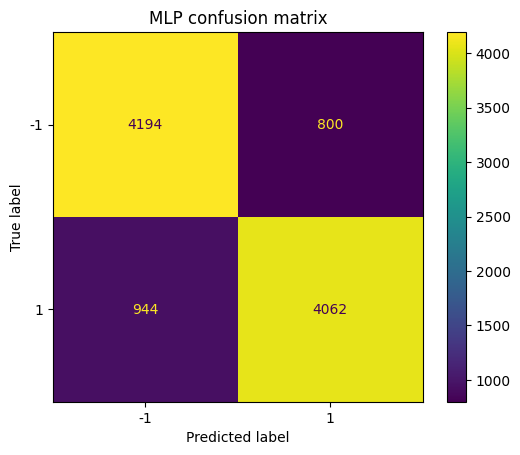

In [22]:
# Test performance with best model
best_P = grid.best_params_["module__hidden_units"]
best_net = grid.best_estimator_    # already trained on full training set

y_test_pred = best_net.predict(X_test_mlp)

acc = accuracy_score(y_test_mlp, y_test_pred)
p_error = 1.0 - acc
cm = confusion_matrix(y_test_mlp, y_test_pred)

print("Test accuracy: {:.4f}".format(acc))
print("Estimated P(error): {:.4f}".format(p_error))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot()
plt.title(f"MLP confusion matrix")
plt.show()


(250000,)
(500, 500)


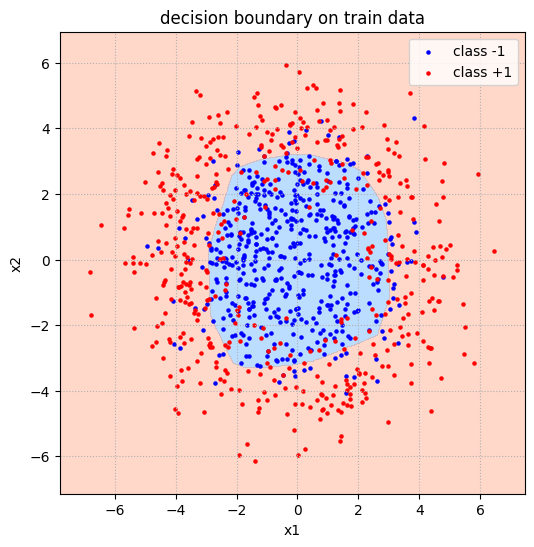

In [23]:
# decision boundaries
x_min, x_max = X_train[:, 0].min() - 1.0, X_train[:, 0].max() + 1.0
y_min, y_max = X_train[:, 1].min() - 1.0, X_train[:, 1].max() + 1.0

# Create mesh
x_mesh, y_mesh = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

grid_points = np.c_[x_mesh.ravel(), y_mesh.ravel()].astype(np.float32)
Z = best_net.predict(grid_points) # get predictions for all grid points
print(Z.shape)
Z = Z.reshape(x_mesh.shape)
print(Z.shape)

plt.figure(figsize=(6, 6))
plt.contourf(x_mesh, y_mesh, Z, levels=[-0.5, 0.5, 1.5], alpha=0.3, colors=['dodgerblue', 'coral']) # decision regions (class 0 vs 1)

# training data (can also map back to {-1,+1})
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], s=5, label="class -1", c="b")
plt.scatter(X_train[y_train == +1, 0], X_train[y_train == +1, 1], s=5, label="class +1", c='r')

plt.xlabel("x1")
plt.ylabel("x2")
plt.title(f"decision boundary on train data")
plt.legend()
plt.grid(True, ls=":")
plt.show()

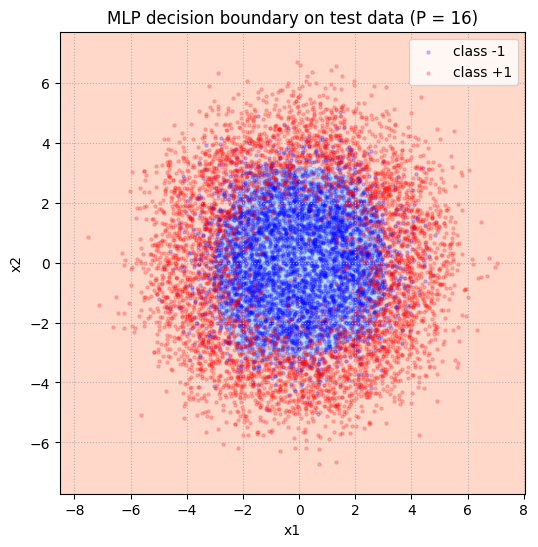

In [24]:
# MLP decision boundary on test data
x_min, x_max = X_test[:, 0].min() - 1.0, X_test[:, 0].max() + 1.0
y_min, y_max = X_test[:, 1].min() - 1.0, X_test[:, 1].max() + 1.0

x_mesh_test, y_mesh_test = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

grid_points_test = np.c_[x_mesh_test.ravel(), y_mesh_test.ravel()].astype(np.float32)
Z_test = best_net.predict(grid_points_test)
Z_test = Z_test.reshape(x_mesh_test.shape)

plt.figure(figsize=(6, 6))
plt.contourf(x_mesh_test, y_mesh_test, Z_test, levels=[-0.5, 0.5, 1.5], alpha=0.3, colors=['dodgerblue', 'coral'])

# test data (back in {-1, +1} using original y_test)
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], s=5, label="class -1", alpha=0.2, c='b')
plt.scatter(X_test[y_test == +1, 0], X_test[y_test == +1, 1], s=5, label="class +1", alpha=0.2, c='r')

plt.xlabel("x1")
plt.ylabel("x2")
plt.title(f"MLP decision boundary on test data (P = {best_P})")
plt.legend()
plt.grid(True, ls=":")
plt.show()